In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, optimize, interpolate
from scipy.integrate import odeint
plt.rcParams.update({'font.size': 18})

D= 0.013875603637000876 k_het = 0.08856415234400061 T= 1223 P= 10000 CMTS0= 0.0894068589830853
(1000,)
(1000,)
n= 10 : at t = 2.78 hours, pore is 19.08 % closed
n= 20 : at t = 5.56 hours, pore is 33.89 % closed
n= 30 : at t = 8.33 hours, pore is 46.02 % closed
n= 40 : at t = 11.11 hours, pore is 55.96 % closed
n= 50 : at t = 13.89 hours, pore is 64.11 % closed
n= 60 : at t = 16.67 hours, pore is 70.78 % closed
n= 70 : at t = 19.44 hours, pore is 76.24 % closed
n= 80 : at t = 22.22 hours, pore is 80.72 % closed
n= 90 : at t = 25.0 hours, pore is 84.38 % closed
n= 100 : at t = 27.78 hours, pore is 87.39 % closed
n= 110 : at t = 30.56 hours, pore is 89.85 % closed
n= 120 : at t = 33.33 hours, pore is 91.87 % closed
n= 130 : at t = 36.11 hours, pore is 93.52 % closed
n= 140 : at t = 38.89 hours, pore is 94.87 % closed
n= 150 : at t = 41.67 hours, pore is 95.98 % closed
n= 160 : at t = 44.44 hours, pore is 96.89 % closed
n= 170 : at t = 47.22 hours, pore is 97.63 % closed
n= 180 : at t = 50

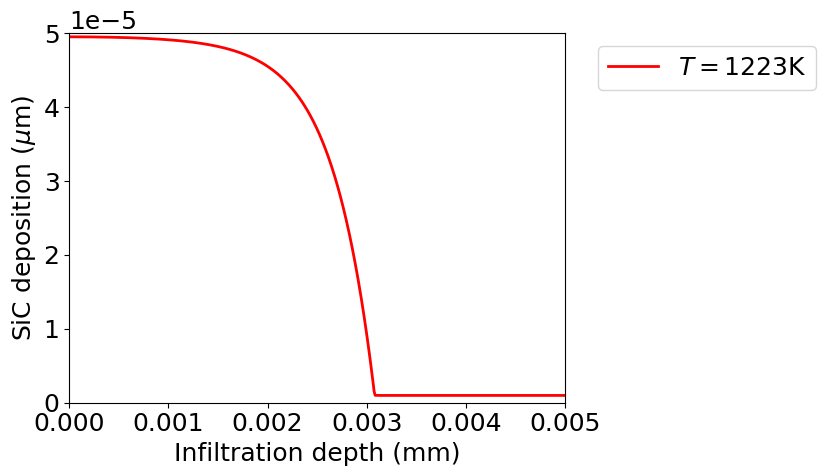

In [5]:
def cvi_sim(Tin,Pin, phi0in, rin, ain,clr,pllbl,dt):
    plotlabel = str(pllbl)
    clr = str(clr)
    phi0 = phi0in
    L = rin*phi0
    rp0 = phi0/2
    nz = 1000
    dt = dt #s
    Zrange = np.linspace(0,L,nz)
    alpha = ain
    P = Pin # Pa
    T = Tin # K
    R = 8.314 # J/mol K
    CMTS0 = (1/(1+alpha))*(P / (R*T)) 
    CH20 = (alpha/(1+alpha))*(P / (R*T)) 
    dCMTS0dz = dCH20dz = 0

    k0 = 3.89e9
    # k0 = 189e9
    Ea = 296e3
    k_het = k0*np.exp(-Ea/(R*T))
    nu = k_het*CMTS0
    dKmts = 3.97 #m/sK^(1/2)
    dKh2 = 34.30 #m/sK^(1/2)
    dKhcl = 8.03 #m/sK^(1/2)
    DKmts=dKmts*phi0*(T**0.5) # m^2/s
    DKh2=dKh2*phi0*(T**0.5) # m^2/s
    DKhcl=dKhcl*phi0*(T**0.5) # m^2/s
    Msic = 0.04011 #kg/mol
    Mmts=0.149 #kg/mol
    Mh2 = 2e-3 #kg/mol
    Mhcl = 3.65e-2 #kg/mol
    rhosic = 3217 #kg/m^3
    # rhomts = 1270
    # rhoh2 = 0.08375
    # rhohcl = 1048
    Vsic=Msic/rhosic #m^3/mol
    Vmts=1.227e-4 #m^3/mol
    Vh2=1.43e-5 #m^3/mol
    Vhcl= 25.3e-5 #m^3/mol
    DFmtsh2=1.360e-3*((T**(3/2))/(P*(Vh2**(1/3)+Vmts**(1/3))**2))*(1/Mh2 + 1/Mmts)**0.5 #Gilliland formula Fedou1993 Appendix 1 Eq A4

    DK = DKmts
    DF = DFmtsh2
    D = (1/DF + 1/DK)**(-1)


    print('D=',D,'k_het =',k_het,'T=',T,'P=',P, 'CMTS0=',CMTS0)

    rpi = rp0*np.ones(nz)
    rp = rpi
    drpdzi = np.zeros(nz)
    drpdz = drpdzi

    # zi = z*nz/L
    # print(zi)

    Ct = []
    rpt = []

    n = 0
    # for i in range(2):

    while any(rp<rp0/100) is not True:

        for j in range(len(Zrange)):
            def C_derivatives(x,z, rpj, drpdzj):
                return [x[1],-x[0]*((2*k_het)/(rpj*D))-x[1]*((2/rpj)*drpdzj)]
            rpj = rp[j]
            drpdzj = drpdz[j]
            C, dCdz = odeint(C_derivatives,[CMTS0,dCMTS0dz], Zrange, args=(rpj,drpdzj)).T
            # if j==2:
            #     print(C-Cnew)
            # Cnew = C

        if n == 1:
            print(C.shape)
            print(dCdz.shape)

        condition = C<0
        if any(condition):
            C[condition.argmax():] = 0

        #rp = rp - dt*2*Vs*k_het
        rp = rp*(1-2*dt*nu*Vsic)
        nu = k_het*C
        drpdz[:-1] = (rp[1:] - rp[:-1])/nz
        drpdz[-1] = drpdz[-2]

        n+=1
        if n % 10 == 0:
            Ct.append(C)
            rpt.append(rp)
            percent_closed = 100*(1 -(rp[0]-rp0/100)/rp0)
            print('n=',n,': at t =',round(n*dt*0.000277778/100,2),'hours, pore is', round(percent_closed,2),'% closed')

    rpl = len(rpt)
    print(n)
    if plotlabel == "none" or plotlabel == "":
        plt.plot(Zrange,(rp0-rp),linewidth=2,color=clr)
    else:
        plt.plot(Zrange,(rp0-rp),label=plotlabel,linewidth=2,color=clr)
    
    # print(rp0-rp)
    lines = str(rp0-rp)
    with open('cvi_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(phi0)+'_ar'+str(L/phi0)+'.txt', 'w') as f:
        f.writelines(lines)
    plt.xlabel(r'Infiltration depth (mm)')
    plt.ylabel(r'SiC deposition ($\mu$m)')
    plt.xlim([0,L/2])
    plt.ylim([0,rp0])
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.savefig('pore_T'+str(T)+'_P'+str(P)+'.png', dpi=220,bbox_inches='tight')    
    
# cvi_sim(1223,10000, 34e-6, 294.117647059, 5,"blue",r"$T=1223$K",100000)
cvi_sim(1223,10000, 100e-6, 100, 10,"red",r"$T=1223$K",100000)




In [3]:

    # k0 = 389e9
    # Ea = 296e3
    # k_het = k0*np.exp(-Ea/(R*T))*CMTS0
    # #k_het = 0.017
    # dK = 3.97
    # DK=dK*phi0*T**0.5 # m^2/s
    # Ms = 0.04011 #kg/mol
    # rhos = 3217 #kg/m^3
    # Vs=Ms/rhos #m^3/mol
    # Mg=0.149 #kg/mol
    # Vg=0.0001227 #m^3/mol
    # DF=1.360e-3*((T**1.5)/(P*(Vg**0.333+Vs**0.333)**2))*(1/Mg + 1/Ms)**0.5 #Gilliland formula Fedou1993 Appendix 1 Eq A4
    # D = (1/DF + 1/DK)**(-1)


In [4]:
    
    # plt.plot(Zrange,rpi,'b--', label=r'$t=0$s',linewidth=2.5)
    # plt.plot(Zrange,rpt[int(1*rpl/5)],'k--', label=r'$t=$%.2fh' %(1*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rpt[int(2*rpl/5)],'k--', label=r'$t=$%.2fh' %(2*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rpt[int(3*rpl/5)],'k--', label=r'$t=$%.2fh' %(3*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rpt[int(4*rpl/5)],'k--', label=r'$t=$%.2fh' %(4*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rp,'r', label=r'$t=$%.2fh, final' %(n*0.000277778*dt/100),linewidth=6.5)
    # plt.ylim([0,rp0])
    # plt.xlim([0,L/2])
    # #rp_init = np.ones(1000)
    # plt.xlabel(r'Depth $(m)$')
    # plt.ylabel(r'Pore radius $(m)$')
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.savefig('rpz.png', dpi=220,bbox_inches='tight')

    # plt.plot(Zrange,rp0-rpi,'b--', label=r'$t=0$s',linewidth=2.5)
    # plt.plot(Zrange,rp0-rpt[int(1*rpl/5)],'k--', label=r'$t=$%.2fh' %(1*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rp0-rpt[int(2*rpl/5)],'k--', label=r'$t=$%.2fh' %(2*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rp0-rpt[int(3*rpl/5)],'k--', label=r'$t=$%.2fh' %(3*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rp0-rpt[int(4*rpl/5)],'k--', label=r'$t=$%.2fh' %(4*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,rp0-rp,'r', label=plotlabel,linewidth=6.5, color=clr)
    # plt.ylim([0,rp0])
    # plt.xlim([0,L/2])
    # #rp_init = np.ones(1000)
    # plt.xlabel(r'Depth $(m)$')
    # plt.ylabel(r'Deposit thickness $(m)$')
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.savefig('dz.png', dpi=220,bbox_inches='tight')

    # initial_initial_C = np.zeros(nz)
    # initial_initial_C[0] = (1/(1+alpha))*(P / (R*T)) 
    # plt.plot(Zrange,initial_initial_C,'g--', label= r'$t=0$s before penetration',linewidth=2.5)
    # plt.plot(Zrange,Ct[0],'b--', label=r'$t=0$s after penetration',linewidth=2.5)
    # plt.plot(Zrange,Ct[int(1*rpl/5)],'k--', label=r'$t=$%.2fh' %(1*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,Ct[int(2*rpl/5)],'k--', label=r'$t=$%.2fh' %(2*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,Ct[int(3*rpl/5)],'k--', label=r'$t=$%.2fh' %(3*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,Ct[int(4*rpl/5)],'k--', label=r'$t=$%.2fh' %(4*n*0.000277778*dt/500),linewidth=1.5)
    # plt.plot(Zrange,C,'r', label=r'$t=$%.2fh, final' %(5*n*0.000277778*dt/500),linewidth=6.5)
    # plt.xlabel(r'$z \ (m)$')
    # plt.ylabel(r'$C \ ($mol$/m^3)$')
    # # plt.ylim([0,rp0])
    # plt.xlim([0,L/2])
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.savefig('Cz.png', dpi=220,bbox_inches='tight')